# Bag of Words for Spam/Ham

In [129]:
import csv 
import io
import requests
from zipfile import ZipFile
import os
import string
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from nltk.stem import PorterStemmer
import tensorflow as tf
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

### Get the Data

In [156]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00228/smsspamcollection.zip"
file_path = "spam_data.csv"

if os.path.isfile(file_path):
    data = []
    with open(file_path, 'r') as file:
        reader = csv.reader(file)
        for row in reader:
            data.append(row)
        print('Data Loaded Sucessfully!')
else:
    req = requests.get(url)
    if req.ok:
        with open(file_path, 'w', newline= '') as file_csv:
            with ZipFile(io.BytesIO(req.content)) as zip_file:
                content = zip_file.read('SMSSpamCollection').decode()
                content = content.encode('ascii', errors= 'ignore')
                content = content.decode().split('\n')
                content = [x.split('\t') for x in content if len(x) > 0]
            writer = csv.writer(file_csv)
            writer.writerows(content)
            print('Data Saved Sucessfully!')
    else:
        raise ConnectionError(f"Something went wrong, request-code: {req.code}.")

Data Loaded Sucessfully!


In [157]:
# Split Reviews and Target
[target, reviews] = [list(x) for x in zip(*data)]

In [158]:
# Pipeline to Text Preprocessing

def preprocessing(samples):
    ps = PorterStemmer()
    samples = [' '.join([ps.stem(word) for word in review.split()]) for review in samples]
    samples = [' '.join(x.lower().split()) for x in samples] # Remove extra spaces and transform to lowe case
    samples = [''.join(c for c in x if c not in string.punctuation and c not in string.digits) 
               for x in samples] # Remove Punctuation marks and Numbers 
    return samples

# Reviews Preprocessing
reviews = preprocessing(reviews)
target = [1. if val == 'spam' else 0. for val in target] # Binarize targets

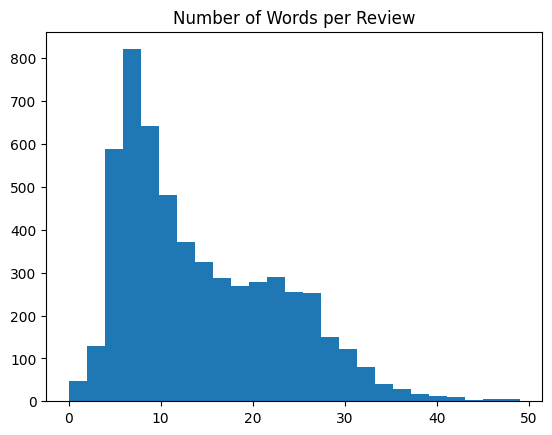

In [159]:
text_lenghts = [len(x.split()) for x in reviews if len(x.split()) < 50]

# Visualize the Length trend
plt.hist(text_lenghts, bins= 25)
plt.title('Number of Words per Review')
plt.show()

In [213]:
# Convert text to sequences
tokenizer = Tokenizer(num_words= 8000)
tokenizer.fit_on_texts(reviews)
text_sequences = tokenizer.texts_to_sequences(reviews) 

# Build a Sparse Tensor
identity_matrix = tf.linalg.diag(tf.ones(shape= [len(tokenizer.index_word)], dtype= tf.float32))
sparse_tensor = []
for sample in text_sequences:
    idx = tf.constant(sample, dtype= tf.int32) - 1
    sparse_tensor.append(tf.reduce_sum(tf.nn.embedding_lookup(identity_matrix, idx), 0).numpy())

In [214]:
# Target Preprocessing
y_cat = tf.keras.utils.to_categorical(target, num_classes= 2)

In [215]:
# Split data into training and testing set
x_train, x_test, y_train, y_test = train_test_split(sparse_tensor, y_cat, train_size= 0.9)
print(f"""
    Training: {len(x_train)}
    Testing: {len(x_test)}
""")


    Training: 5016
    Testing: 558



In [216]:
# Data to Tensor
x_data = tf.constant(x_train, dtype= tf.float32)
y_data = tf.constant(y_train, dtype= tf.float32)

x_test = tf.constant(x_test, dtype= tf.float32)
y_test = tf.constant(y_test, dtype= tf.float32)

In [217]:
from KerasNet import Sequential, Dense, Optimizers

In [228]:
optimizer = Optimizers.RMSprop(learning_rate= 0.01, beta= 0.9)
model = Sequential(optimizer)

model.add(Dense(units= 10, activation='relu', input_dim= x_data.shape[1]))
model.add(Dense(units= 10, activation='relu'))
model.add(Dense(units= 10, activation='relu'))
model.add(Dense(units= 2, activation='softmax'))

model.fit(x_data, y_data, epochs= 30, batch_size= 128)

Epoch: 10 -- Loss: 0.040497083216905594 -- Score: 0.985446572303772
Epoch: 20 -- Loss: 0.008318975567817688 -- Score: 0.9970095753669739
Epoch: 30 -- Loss: 0.004004324320703745 -- Score: 0.9988038539886475


In [231]:
sentences= ["You win a free cup.", "How it is going?"]
sentences_preprocessed = preprocessing(sentences)
sentence_tokenize = tokenizer.texts_to_sequences(sentences_preprocessed)

for s in sentence_tokenize:
    sample = tf.expand_dims(tf.reduce_sum(tf.nn.embedding_lookup(identity_matrix, s), 0), 0)
    print('spam' if model.predict(sample) == 1 else 'ham')

ham
ham


In [248]:
reviews

['go until jurong point crazy avail onli in bugi n great world la e buffet cine there got amor wat',
 'ok lar joke wif u oni',
 'free entri in  a wkli comp to win fa cup final tkt st may  text fa to  to receiv entri questionstd txt ratetc appli over',
 'u dun say so earli hor u c alreadi then say',
 'nah i dont think he goe to usf he live around here though',
 'freemsg hey there darl it been  week now and no word back id like some fun you up for it still tb ok xxx std chg to send  to rcv',
 'even my brother is not like to speak with me they treat me like aid patent',
 'as per your request mell mell oru minnaminungint nurungu vettam ha been set as your callertun for all callers press  to copi your friend callertun',
 'winner as a valu network custom you have been select to receivea  prize reward to claim call  claim code kl valid  hour only',
 'had your mobil  month or more u r entitl to updat to the latest colour mobil with camera for free call the mobil updat co free on ',
 'im gonna 